In [ ]:
import os, time, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

import timm
from transformers import BertTokenizer, BertModel
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
MVTEC_ROOT = Path("/content/drive/MyDrive/mvtec_anomaly_detection")

OBJECTS = [
    "bottle", "cable", "capsule", "carpet", "grid",
    "hazelnut", "leather", "metal_nut", "pill", "screw",
    "tile", "toothbrush", "transistor", "wood", "zipper"
]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class MVTecObjectDataset(Dataset):
    def __init__(self, root, split="train", transform=None):
        self.samples = []
        self.transform = transform
        for obj_id, obj in enumerate(OBJECTS):
            base = Path(root) / obj / split
            if not base.exists(): continue
            for defect in base.iterdir():
                for img_path in defect.glob("*.png"):
                    self.samples.append((img_path, obj_id))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, label

train_ds = MVTecObjectDataset(MVTEC_ROOT, "train", train_tfms)
test_ds  = MVTecObjectDataset(MVTEC_ROOT, "test",  val_tfms)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
text_encoder = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
text_encoder.eval()
for p in text_encoder.parameters(): p.requires_grad = False

prompts = [f"a photo of a {o}" for o in OBJECTS]
tokens = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    txt_feat = text_encoder(**tokens).pooler_output
    txt_feat = txt_feat / txt_feat.norm(dim=1, keepdim=True)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)

lora_cfg = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["qkv", "fc1", "fc2"],
    lora_dropout=0.05,
    bias="none"
)

vit = get_peft_model(vit, lora_cfg).to(DEVICE)
img_proj = nn.Linear(vit.num_features, txt_feat.shape[1]).to(DEVICE)
for p in img_proj.parameters(): p.requires_grad = True

In [ ]:
optimizer = torch.optim.AdamW(list(vit.parameters()) + list(img_proj.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()
temperature = 0.07

In [ ]:
EPOCHS = 10
print(f"\n{'Epoch':<8} | {'Loss':<10} | {'Train Acc':<10} | {'Time':<10}")
print("-" * 45)

for epoch in range(EPOCHS):
    vit.train()
    total_loss, correct, total = 0, 0, 0
    ep_start = time.time()

    for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        # Forward
        img_feat = vit(imgs)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        # Contrastive Similarity Logits
        logits = (img_feat @ txt_feat.T) / temperature
        loss = criterion(logits, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_dl)
    train_acc = (correct / total) * 100
    ep_time = (time.time() - ep_start) / 60
    print(f"{epoch+1:<8} | {avg_loss:<10.4f} | {train_acc:<9.2f}% | {ep_time:<8.2f} min")


Epoch    | Loss       | Train Acc  | Time      
---------------------------------------------


1        | 1.8355     | 64.82    % | 3.67     min


2        | 1.3723     | 92.89    % | 3.65     min


3        | 1.3240     | 95.15    % | 3.62     min


4        | 1.3149     | 96.64    % | 3.64     min


KeyboardInterrupt: 

In [ ]:
prompts = [f"a photo of a {o}" for o in OBJECTS]
tokens = tokenizer(
    prompts,
    padding=True,
    truncation=True,
    return_tensors="pt"
).to(DEVICE)

with torch.no_grad():
    txt_feat = text_encoder(**tokens).pooler_output
    txt_feat = txt_feat / txt_feat.norm(dim=1, keepdim=True)

In [ ]:
vit = timm.create_model(
    "vit_small_patch16_224",
    pretrained=True,
    num_classes=0
)

lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["qkv"],
    lora_dropout=0.1,
    bias="none"
)

vit = get_peft_model(vit, lora_cfg).to(DEVICE)

In [ ]:
img_proj = nn.Linear(vit.num_features, txt_feat.shape[1]).to(DEVICE)

for p in img_proj.parameters():
    p.requires_grad = True

In [ ]:
optimizer = torch.optim.AdamW(
    vit.parameters(),
    lr=1e-4
)

EPOCHS = 10

In [ ]:
train_start = time.time()

for epoch in range(EPOCHS):
    vit.train()
    total_loss = 0
    ep_start = time.time()

    for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        img_feat = vit(imgs)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        target = txt_feat[labels]
        loss = 1 - (img_feat * target).sum(dim=1).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(
        f"Epoch {epoch+1} | "
        f"Loss: {total_loss/len(train_dl):.4f} | "
        f"Time: {(time.time()-ep_start)/60:.2f} min"
    )

train_time = time.time() - train_start
print(f"\nTOTAL TRAIN TIME: {train_time/60:.2f} minutes")

Epoch 1/10: 100%|██████████| 114/114 [02:38<00:00,  1.39s/it]


Epoch 1 | Loss: 0.8312 | Time: 2.65 min


Epoch 2/10: 100%|██████████| 114/114 [02:37<00:00,  1.38s/it]


Epoch 2 | Loss: 0.4069 | Time: 2.63 min


Epoch 3/10: 100%|██████████| 114/114 [02:35<00:00,  1.36s/it]


Epoch 3 | Loss: 0.3344 | Time: 2.59 min


Epoch 4/10: 100%|██████████| 114/114 [02:37<00:00,  1.38s/it]


Epoch 4 | Loss: 0.3187 | Time: 2.62 min


Epoch 5/10: 100%|██████████| 114/114 [02:37<00:00,  1.38s/it]


Epoch 5 | Loss: 0.3124 | Time: 2.62 min


Epoch 6/10: 100%|██████████| 114/114 [02:35<00:00,  1.37s/it]


Epoch 6 | Loss: 0.3082 | Time: 2.60 min


Epoch 7/10: 100%|██████████| 114/114 [02:38<00:00,  1.39s/it]


Epoch 7 | Loss: 0.3052 | Time: 2.64 min


Epoch 8/10: 100%|██████████| 114/114 [02:39<00:00,  1.40s/it]


Epoch 8 | Loss: 0.3031 | Time: 2.67 min


Epoch 9/10: 100%|██████████| 114/114 [02:36<00:00,  1.37s/it]


Epoch 9 | Loss: 0.3016 | Time: 2.61 min


Epoch 10/10: 100%|██████████| 114/114 [02:38<00:00,  1.39s/it]

Epoch 10 | Loss: 0.3004 | Time: 2.64 min

TOTAL TRAIN TIME: 26.25 minutes


In [ ]:
vit.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(DEVICE)

        img_feat = vit(imgs)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        sims = img_feat @ txt_feat.T
        preds = sims.argmax(dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

correct = (y_true == y_pred).sum()
acc = correct / len(y_true)

print(f"REAL Accuracy: {acc*100:.4f}%")
print("Errors:", len(y_true) - correct)

REAL Accuracy: 32.1159%
Errors: 1171


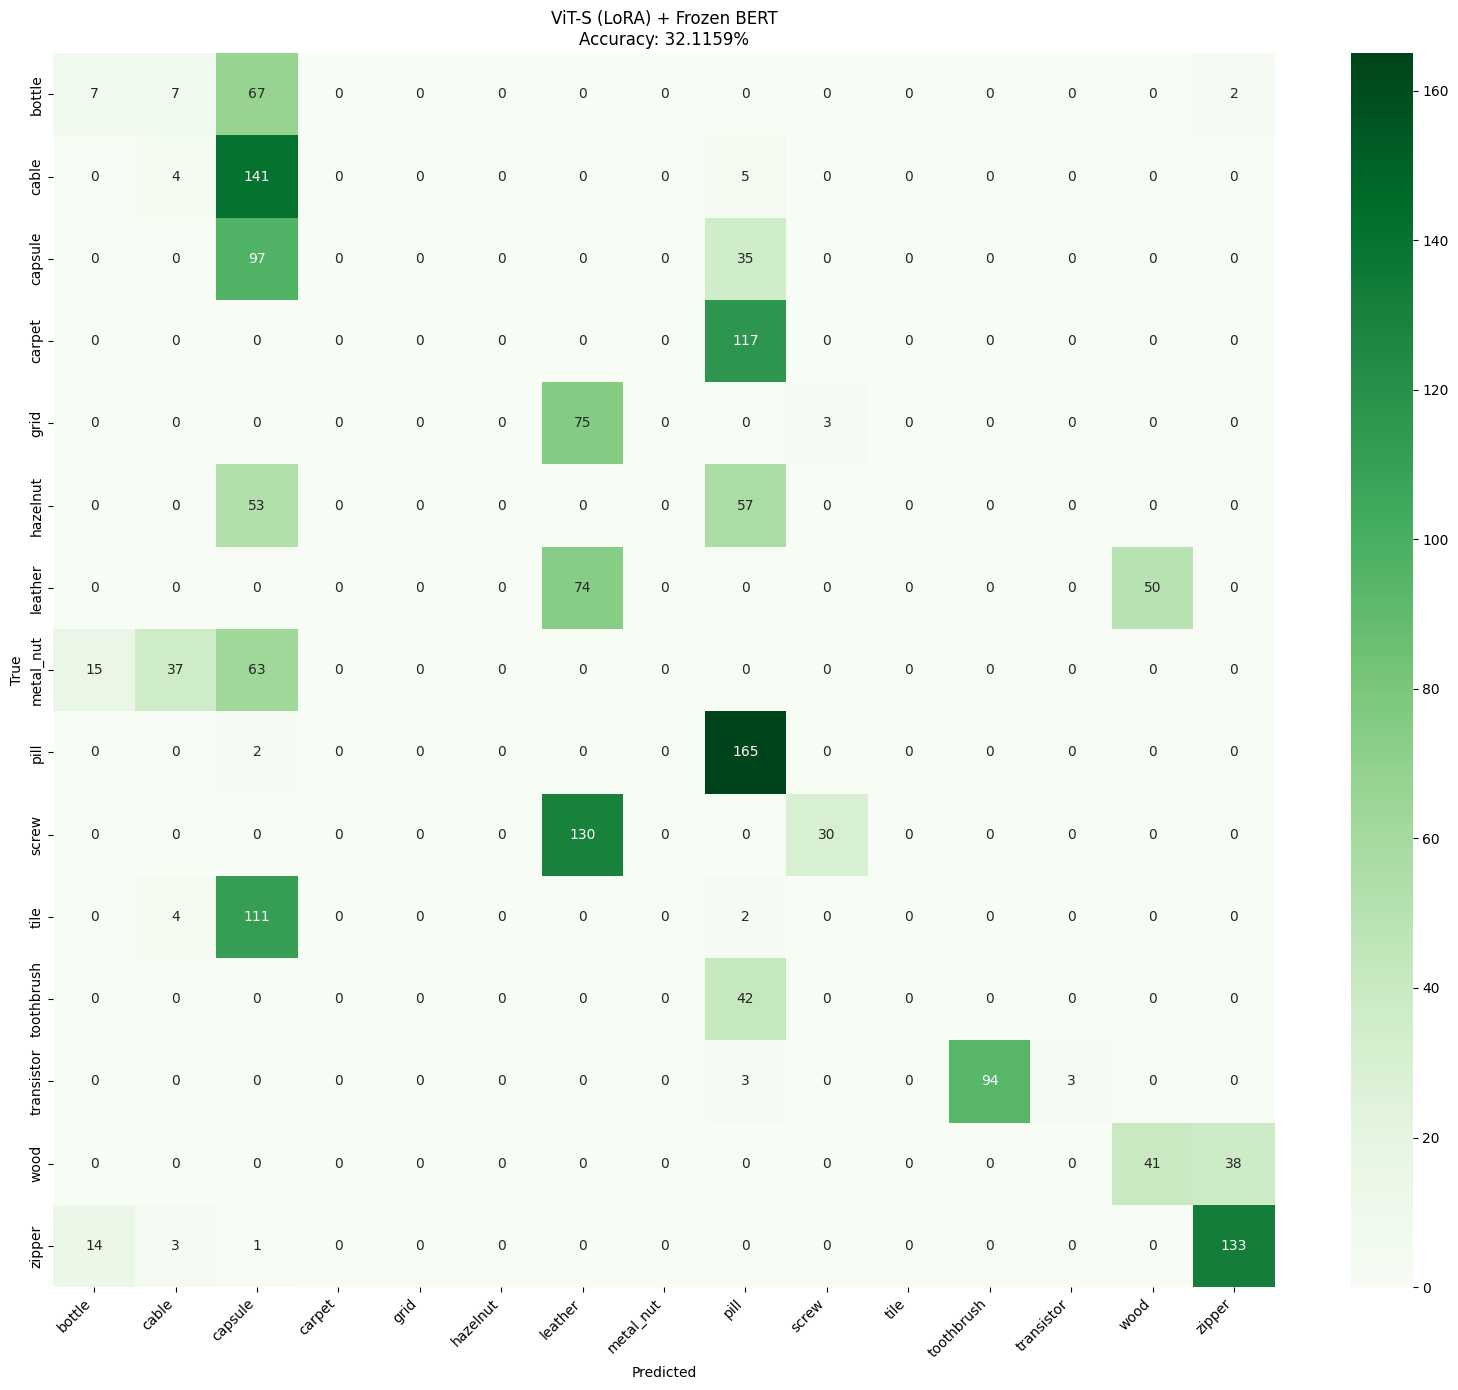

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16,14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Greens"
)
plt.title(f"ViT-S (LoRA) + Frozen BERT\nAccuracy: {acc*100:.4f}%")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
print(
    classification_report(
        y_true, y_pred,
        target_names=OBJECTS,
        digits=4
    )
)

              precision    recall  f1-score   support

      bottle     0.1944    0.0843    0.1176        83
       cable     0.0741    0.0267    0.0392       150
     capsule     0.1711    0.6818    0.2736       132
      carpet     0.0000    0.0000    0.0000       117
        grid     0.0000    0.0000    0.0000        78
    hazelnut     0.0000    0.0000    0.0000       110
     leather     0.2667    0.6129    0.3716       124
   metal_nut     0.0000    0.0000    0.0000       115
        pill     0.3802    0.9880    0.5491       167
       screw     0.8966    0.1625    0.2751       160
        tile     0.0000    0.0000    0.0000       117
  toothbrush     0.0000    0.0000    0.0000        42
  transistor     1.0000    0.0300    0.0583       100
        wood     0.4667    0.5316    0.4970        79
      zipper     0.7701    0.8874    0.8246       151

    accuracy                         0.3171      1725
   macro avg     0.2813    0.2670    0.2004      1725
weighted avg     0.3148   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
vit.eval()
dummy = torch.randn(1,3,224,224).to(DEVICE)

# warmup
for _ in range(20):
    _ = vit(dummy)

N = 100
start = time.time()
for _ in range(N):
    _ = vit(dummy)
end = time.time()

lat = (end - start) / N * 1000
print(f"Inference latency: {lat:.2f} ms / image")

Inference latency: 9.48 ms / image


In [ ]:
for p in img_proj.parameters():
    p.requires_grad = True

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

vit_trainable = count_parameters(vit)
proj_trainable = count_parameters(img_proj)
total_trainable = vit_trainable + proj_trainable

def count_all_params(model):
    return sum(p.numel() for p in model.parameters())

total_vit_params = count_all_params(vit)

print("-" * 55)
print(f"{'Configuration Parameter':<30} | {'Value':<20}")
print("-" * 55)
print(f"{'ViT Variant':<30} | ViT-Small (patch 16)")
print(f"{'ViT Internal Embed Dim':<30} | {vit.num_features}")
print(f"{'BERT Embed Dim (Target)':<30} | {txt_feat.shape[1]}")
print(f"{'Image Projection':<30} | Linear(384 -> 768)")
print(f"{'LoRA Rank (r)':<30} | {lora_cfg.r}")
print(f"{'LoRA Alpha':<30} | {lora_cfg.lora_alpha}")
print("-" * 55)
print(f"{'Trainable LoRA Weights':<30} | {vit_trainable:,}")
print(f"{'Trainable Proj Layer':<30} | {proj_trainable:,}")
print(f"{'Total Trainable Params':<30} | {total_trainable:,}")
print(f"{'Total Model Params':<30} | {total_vit_params + proj_trainable:,}")
print(f"{'Percentage Trainable':<30} | {(total_trainable / (total_vit_params + proj_trainable)) * 100:.2f}%")
print("-" * 55)

-------------------------------------------------------
Configuration Parameter        | Value               
-------------------------------------------------------
ViT Variant                    | ViT-Small (patch 16)
ViT Internal Embed Dim         | 384
BERT Embed Dim (Target)        | 768
Image Projection               | Linear(384 -> 768)
LoRA Rank (r)                  | 8
LoRA Alpha                     | 16
-------------------------------------------------------
Trainable LoRA Weights         | 147,456
Trainable Proj Layer           | 295,680
Total Trainable Params         | 443,136
Total Model Params             | 22,108,800
Percentage Trainable           | 2.00%
-------------------------------------------------------


In [ ]:
pip install ptflops

In [ ]:
!pip install fvcore -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# 1. Create a dummy input matching your test transform (1 image, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)

# 2. Wrap your pipeline into one object for analysis
class InferenceModule(nn.Module):
    def __init__(self, vit, proj):
        super().__init__()
        self.vit = vit
        self.proj = proj
    def forward(self, x):
        features = self.vit(x)
        return self.proj(features)

# 3. Load the model for analysis
model_to_profile = InferenceModule(vit, img_proj).eval()

# 4. Perform the analysis
flops = FlopCountAnalysis(model_to_profile, dummy_input)

print(f"Total GFLOPs: {flops.total() / 1e9:.4f}")
print(f"Total GMACs:  {(flops.total() / 2) / 1e9:.4f}")
print("\n--- Detailed Breakdown ---")
print(flop_count_table(flops))

vit.base_model.model.blocks.0.attn.attn_drop, vit.base_model.model.blocks.1.attn.attn_drop, vit.base_model.model.blocks.10.attn.attn_drop, vit.base_model.model.blocks.11.attn.attn_drop, vit.base_model.model.blocks.2.attn.attn_drop, vit.base_model.model.blocks.3.attn.attn_drop, vit.base_model.model.blocks.4.attn.attn_drop, vit.base_model.model.blocks.5.attn.attn_drop, vit.base_model.model.blocks.6.attn.attn_drop, vit.base_model.model.blocks.7.attn.attn_drop, vit.base_model.model.blocks.8.attn.attn_drop, vit.base_model.model.blocks.9.attn.attn_drop


Total GFLOPs: 4.2796
Total GMACs:  2.1398

--- Detailed Breakdown ---
| module                                          | #parameters or shape   | #flops    |
|:------------------------------------------------|:-----------------------|:----------|
| model                                           | 22.109M                | 4.28G     |
|  vit.base_model.model                           |  21.813M               |  4.279G   |
|   vit.base_model.model.cls_token                |   (1, 1, 384)          |           |
|   vit.base_model.model.pos_embed                |   (1, 197, 384)        |           |
|   vit.base_model.model.patch_embed.proj         |   0.295M               |   57.803M |
|    vit.base_model.model.patch_embed.proj.weight |    (384, 3, 16, 16)    |           |
|    vit.base_model.model.patch_embed.proj.bias   |    (384,)              |           |
|   vit.base_model.model.blocks                   |   21.441M              |   4.221G  |
|    vit.base_model.model.blocks.0      

Load the model directly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_PATH = "/content/drive/MyDrive/new-step2_vits_lora.pth"

torch.save({
    "vit_state": vit.state_dict(),
    "img_proj_state": img_proj.state_dict(),
    "objects": OBJECTS,
}, SAVE_PATH)

print("aved to Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
aved to Google Drive


In [ ]:
import torch
import torch.nn as nn
import timm
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OBJECTS = [
    "bottle", "cable", "capsule", "carpet", "grid",
    "hazelnut", "leather", "metal_nut", "pill", "screw",
    "tile", "toothbrush", "transistor", "wood", "zipper"
]

In [ ]:
vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=0)
lora_cfg = LoraConfig(
    r=8, lora_alpha=16, target_modules=["qkv"], lora_dropout=0.1, bias="none"
)
vit = get_peft_model(vit, lora_cfg).to(DEVICE)

img_proj = nn.Linear(vit.num_features, 768).to(DEVICE)

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/new-step2_vits_lora.pth"
checkpoint = torch.load(SAVE_PATH)
vit.load_state_dict(checkpoint["vit_state"])
img_proj.load_state_dict(checkpoint["img_proj_state"])

vit.eval()
img_proj.eval()

Linear(in_features=384, out_features=768, bias=True)

In [ ]:
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs = imgs.to(DEVICE)
        img_feat = vit(imgs)
        img_feat = img_proj(img_feat)
        img_feat = img_feat / img_feat.norm(dim=1, keepdim=True)

        sims = img_feat @ txt_feat.T
        preds = sims.argmax(dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

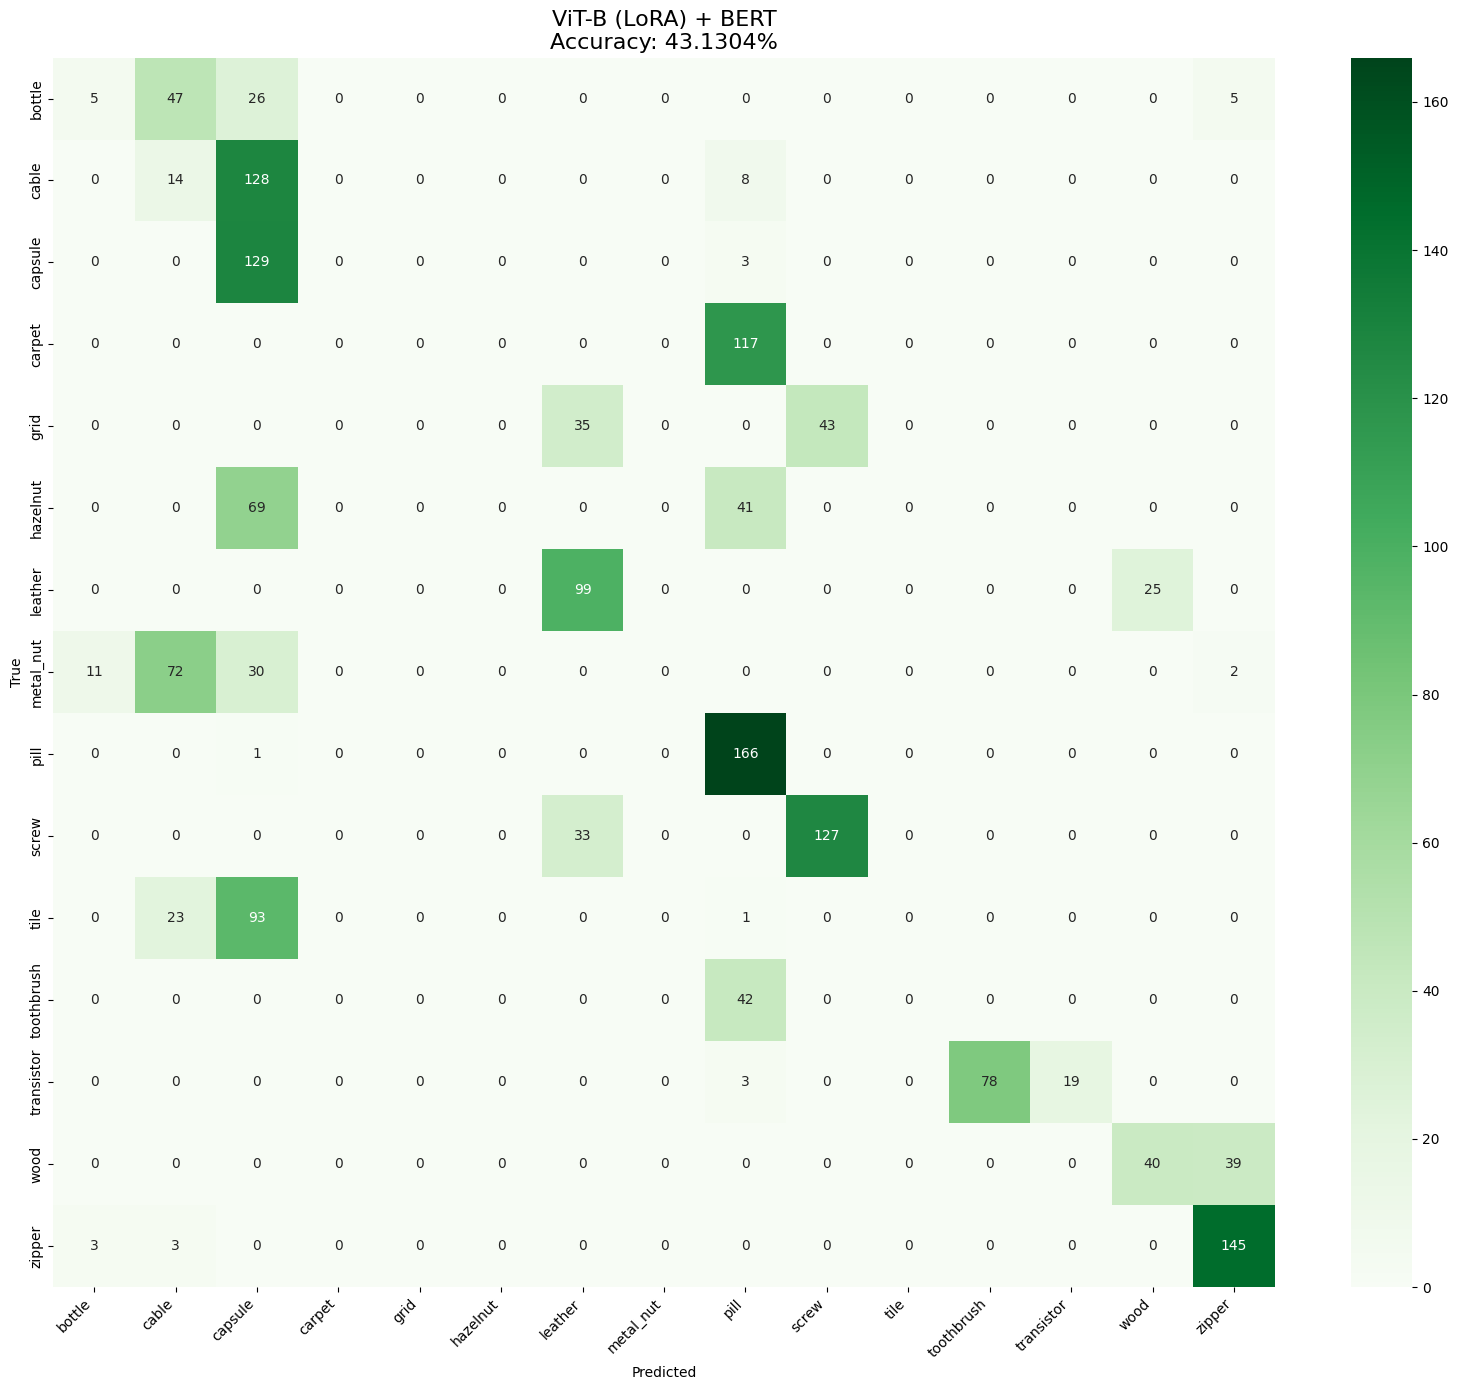


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      bottle     0.2632    0.0602    0.0980        83
       cable     0.0881    0.0933    0.0906       150
     capsule     0.2710    0.9773    0.4243       132
      carpet     0.0000    0.0000    0.0000       117
        grid     0.0000    0.0000    0.0000        78
    hazelnut     0.0000    0.0000    0.0000       110
     leather     0.5928    0.7984    0.6804       124
   metal_nut     0.0000    0.0000    0.0000       115
        pill     0.4357    0.9940    0.6058       167
       screw     0.7471    0.7937    0.7697       160
        tile     0.0000    0.0000    0.0000       117
  toothbrush     0.0000    0.0000    0.0000        42
  transistor     1.0000    0.1900    0.3193       100
        wood     0.6154    0.5063    0.5556        79
      zipper     0.7592    0.9603    0.8480       151

    accuracy                         0.4313      1725
   macro avg     0.3182    0.3582    0.2928     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
acc = accuracy_score(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm, annot=True, fmt="d",
    xticklabels=OBJECTS,
    yticklabels=OBJECTS,
    cmap="Greens"
)
plt.title(f"ViT-B (LoRA) + BERT\nAccuracy: {acc*100:.4f}%", fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(
    classification_report(
        y_true, y_pred,
        target_names=OBJECTS,
        digits=4
    )
)